# 💻 UnpackAI DL201 Bootcamp - Week 1 - Skills: Computer Vision

## 📕 Learning Objectives

* Loading data
* Unzipping data
* Retrieving label information
* AI model training and results analysis on Computer Vision

# Part 0 : Code preparation

In [2]:
import pandas as pd
import numpy as np
import cv2 
import torch as t
from matplotlib import pyplot as plt
from pathlib import Path
import os
from shutil import unpack_archive
from PIL import Image
from IPython.display import display

# import data and images if necessary, and choose the right path
is_kaggle = True   # True if you are on Kaggle, False for local Windows, Linux or Mac environments.

if is_kaggle:
    !pip install openpyxl
    !git clone https://github.com/unpackAI/DL201.git
    IMAGE_DIR = Path('/kaggle/working/DL201/img')
    DATA_DIR = Path('/kaggle/working/DL201/data')

else:

    # This section is for local execution, it is assumed that the notebook is on the 'Week-1' folder
    # of the DL201 repository.
    current_dir = os.getcwd()
    os.chdir("..")
    DATA_DIR = os.path.join(os.getcwd(), "data")
    IMAGE_DIR = os.path.join(os.getcwd(), "img")    


# finally, check if we found the right pathes
if os.path.isdir(DATA_DIR):
    print(f'DATA_DIR is a directory, its path is {DATA_DIR}')
else:
    print("ERROR : DATA_DIR is not a directory")

if os.path.isdir(IMAGE_DIR):
    print(f'IMAGE_DIR is a directory, its path is {IMAGE_DIR}')
else:
    print("ERROR : IMAGE_DIR is not a directory")

DATA_DIR is a directory, its path is d:\GitHub\DL201\data
IMAGE_DIR is a directory, its path is d:\GitHub\DL201\img


# Part 1: Loading the data
<hr style="border:4px solid gray"> </hr>

As always, the question becomes, how do we access our data.

## 1.1 How Large is the dataset?

Before downloading the data, it is a good idea to know how large the dataset is because this will affect how you move forward. If it is very large, you may need to consider if you can download it or not, how much time this would take, how it will be stored in your computer, etc.

You may need to select a sample out of the dataset to work with rather than work with the whole set. This will speed up exploring the data because you won't constantly be waiting for the computer to process the data.

This information is usually found online, in the Readme following the data or displayed by your computer when you start downloading.

## 1.2 Working with compressed files?

***Zip*** files are incredibly common in many areas.

For datasets, they serve two primary purposes:

1. This format bundles together many files into one and makes it easier and faster to send it over the internet. Network protocols are similar to the mail. It's much less complicated to send a shipping container rather than do paperwork and handling of thousands of individual boxes.

2. Compression. The other problem is bandwidth. Zip files, along with other formats, can make files smaller which is beneficial because they take up less space on the hard drive. More importantly, this means that we can download the dataset faster. 

### Step 1: Find the exact file path

In [4]:
# Setting the file path using pathlib
emotionsImagesZipPath = os.path.join(DATA_DIR, 'CV', 'Emotions_Images_Sample.zip')
os.path.isfile(emotionsImagesZipPath)

True

### Step 2: Unzip the files

In this code, we are using a library called ***shutil***
Shutil is short for shell utility.

This allows python to make commands in the shell.

In this case, we are telling it to unzip a file X and put it in Y directory.
X is a file path while Y is a directory path.

In [5]:
Output_Directory = os.path.join(DATA_DIR,'OutputDirectory')

if not os.path.isdir(Output_Directory): #this allows us to run the cell several times
    os.mkdir(Output_Directory)
    unpack_archive(emotionsImagesZipPath, Output_Directory)

### Step 3: Check the file path

Now that we extracted the data, we now need to make sure that we know where our data is, and check up on it before proceeding to the next level.

Check the output of the next command and see what it is doing.

In [6]:
os.listdir(Output_Directory)

['Emotions_Images_Sample']

In [7]:
EMOTIONS_IMAGES_DIR = os.path.join(Output_Directory,'Emotions_Images_Sample')
labels = os.listdir(EMOTIONS_IMAGES_DIR)
print(labels)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


Here, we see a list of labels as directory names. Let's remind the different ways to connect the pictures and their metadata such as labels.

## 1.3 Ways of storing the data and metadata

Many computer vision data sets are organized in three ways.

<dt>File trees</dt>
<df>The picture files are grouped by meaningfull directories. We may find their label and other information about them with the directory they belong to. Finding them is done by exploring what is called a ***file tree***</df>

<dt>Metadata</dt>
<df>The picture files are not well separated in the file tree, or might even be stored on different repositories on the web. To retrieve them and the corresponding labels, we have a Metadata file (can be a JSON or CSV file) containing the file list, file paths and other information like the labels</df>

<dt>File names</dt>
<df>As we saw in the PETS dataset, where cats were lowercases and dogs were uppercases file names, some pictures of some datasets contain their label inside the filename itself</df>

## 1.4 Class analysis from file tree
Here, the labels are conveniently stored as directory names, so they are easy to extract.

In [8]:
print(f'total number of labels: {len(labels)}')

total number of labels: 7


In [9]:
instancesPerClassDict = {}

filepathDictionary = {}

for label in os.listdir(EMOTIONS_IMAGES_DIR):
    
    # This gives us a label for each bit of code
    imagesDirectory = os.path.join(EMOTIONS_IMAGES_DIR,label)
    
    # This code gives a list of all the images in the directory
    
    images = os.listdir(imagesDirectory)
    for fileName in images:
        
        imagePath = os.path.join(imagesDirectory,fileName) # makes a longer path
        # use imagePath to do something
            
    instancesPerClassDict[label] = len(images)
    
for key, value in instancesPerClassDict.items():
    print(f'Class: ({key}) contains {value} instances')


Class: (Angry) contains 51 instances
Class: (Disgust) contains 51 instances
Class: (Fear) contains 51 instances
Class: (Happy) contains 51 instances
Class: (Neutral) contains 51 instances
Class: (Sad) contains 51 instances
Class: (Surprise) contains 101 instances


Now, we have our data in a format that it can be put into a fastAI model to give us more information.

## 1.5 Class analysis from Metadata File

In some cases, the files may be located on a cloud server, or put together into one large directory. This means that the information is not organized with a file tree, but rather in metadata.

This metadata can come as a CSV or a JSON File.

Here, we work with the google landmarks image dataset, it contains lots of information on different photos that users have uploaded along with different kinds of metadata.

However, the  dataset is quite large, so it makes more sense to have an individual metadata files. It can allows us to donwload only the pictures we want.

These metadata files contain both the labels and the file paths that we need.

***Identifying the x and the y***
The features (x) in this case are the images ; labels (y) in this case are the landmark IDs.

In [10]:
# Load 3 sample images from the Google Ladmark dataset
image_path_1 = os.path.join(IMAGE_DIR, "week1", "IMG_1071.jpg")
image_path_2 = os.path.join(IMAGE_DIR, "week1", "IMG_2053p.jpg")
image_path_3 = os.path.join(IMAGE_DIR, "week1", "IMG_20130605_142805.jpg")
image_object_1 = Image.open(image_path_1)
image_object_2 = Image.open(image_path_2) 
image_object_3 = Image.open(image_path_3)  

In [11]:
# Resize the image to 25% of its original size
image_object_1 = image_object_1.resize((int(image_object_1.width/4), int(image_object_1.height/4)))
image_object_2 = image_object_2.resize((int(image_object_2.width/4), int(image_object_2.height/4)))
image_object_3 = image_object_3.resize((int(image_object_3.width/4), int(image_object_3.height/4)))

In [ ]:
# Display the images (Run this cell)
display(image_object_1)
display(image_object_2)
display(image_object_3)

Examples of the Landmarks dataset: The link for the images is contained on the metadata file.

In [13]:
googleLandmarksPath = os.path.join(DATA_DIR,'CV','landmarks')
os.path.isdir(googleLandmarksPath)

True

In [26]:
# List the CSV files from the Google Landmarks dataset folder
landmarks_csv_data = dict()
csv_filenames = os.listdir(googleLandmarksPath)
print(f"CSV files on dataset folder: {csv_filenames}")


CSV files on dataset folder: ['boxes_split1.csv', 'boxes_split2.csv', 'index.csv', 'landmarksample.csv', 'recognition_solution.csv', 'retrieval_solution.csv', 'test.csv', 'train.csv']


In [27]:
# Load the CSV files using a dictionary: the key is the file name and the value is a dataframe with the contents of the file
for csv_filename in csv_filenames:
    csv_path = os.path.join(googleLandmarksPath, csv_filename)
    landmarks_csv_data[csv_filename] = pd.read_csv(csv_path, delimiter=',')

Now that we loaded all the metadata files. We will look at their name to know what they represent, and check their shape to know rapidly the number of features and sample they describe. If the name of the file is not clear enough, we can sometimes get some information by observing the relationships between the shapes of two files.

In [28]:
# Inspect the file "train.csv" as an example
print(f"- Size of the 'train.csv' file: {landmarks_csv_data['train.csv'].shape}")
print(landmarks_csv_data['train.csv'].head())

- Size of the 'train.csv' file: (2000, 4)
   Unnamed: 0                id  \
0     1221181  638a7921e893de63   
1      393869  ec108f2c67d28082   
2      833769  8b8d9329e3fccd0a   
3      400348  cf6b02c51de2f6a1   
4      749128  c798f1620d54d8c1   

                                                 url landmark_id  
0  http://lh6.ggpht.com/-okvU3kjsKWQ/TjnHZCjgLdI/...        3918  
1  https://lh4.googleusercontent.com/-ghGLWnz_5Nw...        4786  
2  https://lh4.googleusercontent.com/-49VHsrW3voo...        6090  
3  http://lh6.ggpht.com/-6Afsd7_E_ck/RsSKkV5EnnI/...        6051  
4                                               None        None  


In [29]:
landmarks_csv_data['train.csv'].drop(['Unnamed: 0'],axis=1,inplace=True)
print(landmarks_csv_data['train.csv'].shape)
landmarks_csv_data['train.csv'].head()

(2000, 3)


,id,url,landmark_id
0,638a7921e893de63,http://lh6.ggpht.com/-okvU3kjsKWQ/TjnHZCjgLdI/...,3918
1,ec108f2c67d28082,https://lh4.googleusercontent.com/-ghGLWnz_5Nw...,4786
2,8b8d9329e3fccd0a,https://lh4.googleusercontent.com/-49VHsrW3voo...,6090
3,cf6b02c51de2f6a1,http://lh6.ggpht.com/-6Afsd7_E_ck/RsSKkV5EnnI/...,6051
4,c798f1620d54d8c1,None,None


In this dataset, the label is the landmark ID

The file location is a little more tricky because it is stored on google's servers, and needs to be downloaded. 

In [30]:
landmarkLabels = landmarks_csv_data['train.csv']['landmark_id']
landmarkURLs = landmarks_csv_data['train.csv']['url']

Although these are different, the principles remain the same as before : we need to know what the image is, and where the image is stored. The label and the file path/url will hold this information.

You can check another example here : https://www.kaggle.com/piyushrg/computer-vision-av-fastai/notebook

## Part 2 : Loading the data into the dataloader
<hr style="border:4px solid gray"> </hr>


In order to leverage a fastAI model, the two key pieces of information that we will need to fit the data into the model are the ***labels***, and how the images are stored. 

Once we can do that, we can go ahead and train a ***preliminary model*** to get quantified information on how to build the final model.

In [33]:
# Imports, this cell must be run twice because there are dependencies problems with the preloaded libraries of Kaggle
!pip install -Uqq fastbook[full]

from fastbook import *
from fastai.vision.widgets import *
setup_book()

### Loading the Data into FastAI Dataloader

Once we have the paths of each image, we can use a dataloader to preprocess and transform the data automatically for us using FastAI

In [34]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [35]:
emotions = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=99),
    get_y=parent_label,
    item_tfms=Resize(225,225)
    )

In [36]:
emotions = emotions.new(
    item_tfms=RandomResizedCrop(28, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [37]:
dls = emotions.dataloaders(EMOTIONS_IMAGES_DIR)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [ ]:
dls.valid.show_batch(max_n=16, nrows=4)

# Part 3 : Training the Model

In [39]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

c:\Users\lenis\miniconda3\envs\DL201\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\lenis/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:31<00:00, 2.78MB/s]


In [40]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,3.256791,2.959296,0.913580,00:05


epoch,train_loss,valid_loss,error_rate,time
0,3.162385,2.722958,0.901235,00:11
1,3.010534,2.497166,0.876543,00:10
2,2.921787,2.453059,0.864198,00:10
3,2.891099,2.432964,0.814815,00:11
4,2.877030,2.501717,0.814815,00:12


# Part 4: Interpreting the Results

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

### What is the Accuracy of the Model?

In [42]:
interp.print_classification_report()

              precision    recall  f1-score   support

       Angry       0.18      0.57      0.28         7
     Disgust       0.11      0.12      0.12        16
        Fear       0.00      0.00      0.00        10
       Happy       0.14      0.12      0.13         8
     Neutral       0.33      0.17      0.22        12
         Sad       0.15      0.33      0.21         9
    Surprise       0.75      0.16      0.26        19

    accuracy                           0.19        81
   macro avg       0.24      0.21      0.17        81
weighted avg       0.29      0.19      0.18        81



### What Does the Confusion Matrix Look Like?

interp.confusion

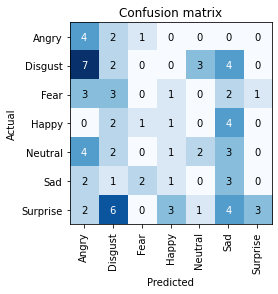

In [43]:
interp.plot_confusion_matrix()

1. Do you see any clear patterns in the confusion matrix?

2. Can you find any poor quality images?

3. Where Does this First Run Strengthen your Hypothesis?

4. What is a file path? What information does it contain?
    - A. A file path always refers to a folder on a computer, it can contain many files inside of it
    - B. A file path the location of a file or directory in a file system, it tells the computer where to look for a particular file
    - C. A file path is the name of a file, and doesn't include the parent directories e.g. image3.jpg

5. What does the working/current directory mean? Why is it important to know this when using Jupyter Notebook? 
    - A. It is the directory/folder that the user is currently working in. The file paths in your program are relative to your working directory
    - B. It is the equivalent of the home directory/folder. It is the base of the file tree.
    - C. AI can figure this out, don't worry because it is intelligent. 

6. Where can one extract the labels from a dataset of images zipped together in a file tree? What is the most common place, where is also oless common?
    - A. The home directory
    - B. Inside of the file path e.g. Cars/Sedan/5316.jpg
    - C. Inside of a column in a table of metadata
    - D. The file extension
	